In [8]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

In [9]:
# This should print something along the lines of '2.0.0-rc1'
tf.__version__

'2.4.0'

In [49]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [50]:
# MNIST
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

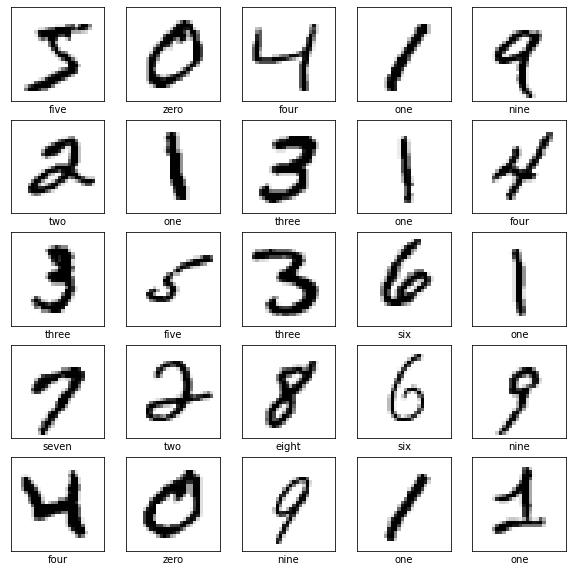

In [51]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])
plt.show()

In [52]:
# Pre-process data
img_rows, img_cols, channels = 28, 28, 1 # 32, 32, 3
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [66]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),    
    tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.fit(x_train, y_train,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 2s 945us/step - loss: 0.4504 - accuracy: 0.8710 - val_loss: 0.1255 - val_accuracy: 0.9604
Epoch 2/10
1875/1875 [==============================] - 2s 821us/step - loss: 0.1114 - accuracy: 0.9669 - val_loss: 0.0941 - val_accuracy: 0.9714
Epoch 3/10
1875/1875 [==============================] - 2s 856us/step - loss: 0.0754 - accuracy: 0.9771 - val_loss: 0.0851 - val_accuracy: 0.9745
Epoch 4/10
1875/1875 [==============================] - 2s 892us/step - loss: 0.0577 - accuracy: 0.9819 - val_loss: 0.0868 - val_accuracy: 0.9732
Epoch 5/10
1875/1875 [==============================] - 2s 917us/step - loss: 0.0439 - accuracy: 0.9861 - val_loss: 0.0834 - val_accuracy: 0.9747
Epoch 6/10
1875/1875 [==============================] - 2s 866us/step - loss: 0.0353 - accuracy: 0.9888 - val_loss: 0.0800 - val_accuracy: 0.9773
Epoch 7/10
1875/1875 [==============================] - 2s 836us/step - loss: 0.0311 - accuracy: 0.9894 - val_loss: 0.0938 -

In [69]:
# Assess base model accuracy on regular images
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.08059047907590866, 0.9796000123023987]


In [70]:
# Function to create adversarial pattern
def adversarial_pattern(image, label):

    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        
        label = label.reshape(1, -1)

        loss = tf.keras.losses.CategoricalCrossentropy()
        loss = loss(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

five
three


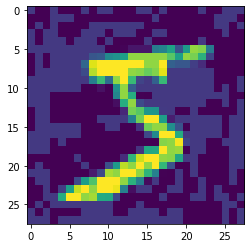

In [71]:
# Create a signle adversarial example
image = x_train[0]
image_label = y_train[0]

perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + perturbations * 0.1

print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))

plt.show()

In [72]:
# Adversarial data generator
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

Prediction: four , Truth: nine


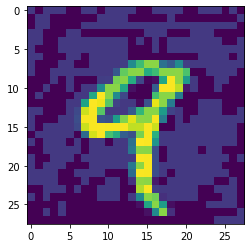

Prediction: three , Truth: nine


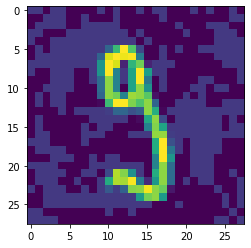

Prediction: three , Truth: zero


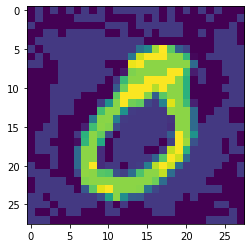

Prediction: nine , Truth: seven


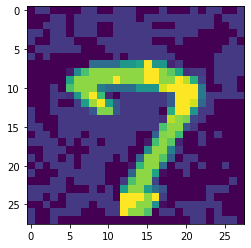

Prediction: three , Truth: five


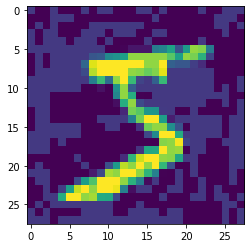

Prediction: three , Truth: zero


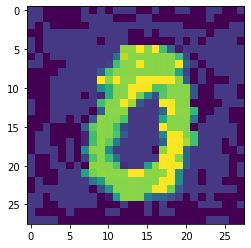

Prediction: eight , Truth: one


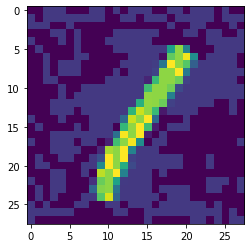

Prediction: three , Truth: two


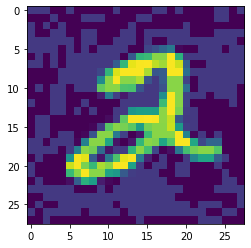

Prediction: three , Truth: three


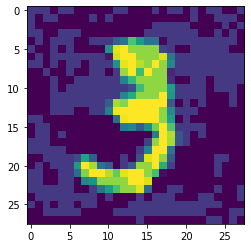

Prediction: eight , Truth: one


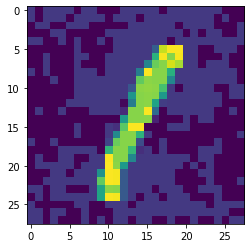

Prediction: three , Truth: seven


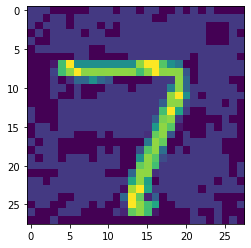

Prediction: zero , Truth: zero


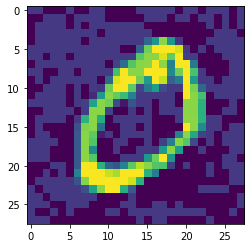

In [73]:
# Generate and visualize 12 adversarial images
adversarials, correct_labels = next(generate_adversarials(12))
for adversarial, correct_label in zip(adversarials, correct_labels):
    print('Prediction:', labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()], ', Truth:', labels[correct_label.argmax()])
    if channels == 1:
        plt.imshow(adversarial.reshape(img_rows, img_cols))
    else:
        plt.imshow(adversarial)
    plt.show()

In [74]:
# Generate adversarial data
# x_adversarial, y_adversarial = np.load("x_adv_10k.npy"), np.load("y_adv_10k.npy")
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))

x_adversarial_test2, y_adversarial_test2 = next(generate_adversarials(10000))

In [75]:
# Assess base model on adversarial data
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [11.01753044128418, 0.1956000030040741]


In [76]:
# Learn from adversarial data
model.fit(x_adversarial_train, y_adversarial_train,
          epochs=5,
          validation_data=(x_test, y_test))

Epoch 1/5
625/625 [==============================] - 1s 1ms/step - loss: 0.1248 - accuracy: 0.9807 - val_loss: 1.2606 - val_accuracy: 0.6937
Epoch 2/5
625/625 [==============================] - 1s 1ms/step - loss: 3.2199e-04 - accuracy: 1.0000 - val_loss: 1.3101 - val_accuracy: 0.6962
Epoch 3/5
625/625 [==============================] - 1s 1ms/step - loss: 1.3449e-04 - accuracy: 1.0000 - val_loss: 1.3516 - val_accuracy: 0.6968
Epoch 4/5
625/625 [==============================] - 1s 1ms/step - loss: 7.1941e-05 - accuracy: 1.0000 - val_loss: 1.3845 - val_accuracy: 0.6975
Epoch 5/5
625/625 [==============================] - 1s 1ms/step - loss: 4.2579e-05 - accuracy: 1.0000 - val_loss: 1.4120 - val_accuracy: 0.6990


In [77]:
# Assess defended model on adversarial data
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

# Assess defended model on regular data
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Defended accuracy on adversarial images: [3.3070497011067346e-05, 1.0]
Defended accuracy on regular images: [1.4119677543640137, 0.6990000009536743]


In [78]:
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test2, y=y_adversarial_test2, verbose=0))

Defended accuracy on adversarial images: [3.3660424378467724e-05, 1.0]


- Dense로 구성한 네트워크는 adversarial attack에 특히 취약함